<a href="https://colab.research.google.com/github/movie112/INU-DILAB/blob/main/210728_210810/disaster_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not
<https://www.kaggle.com/c/nlp-getting-started/overview>
---
단어들을 벡터화 시키는 방법
1. CountVectorizer : 빈도수를 기반으로 vocabulary를 만들고 그 vocabulary를 기준으로 vector를 만들어준다. *모든 단어가 vocabulary에 있는 것이 아니라, 문장 간 2개이상(?)에 쓰인 단어만 포함됨, 텍스트 데이터에서 횟수(선택)를 기준으로 특징 추출
2. Tokenizer: 빈도수를 상관하지 않고 모든 단어에 대해 vector를 만들어준다. one-hot encoding, 근데 마지막으로 어차피 one-hot encoding 한거를 합쳐서 문장벡터를 만들거기 때문에 결과적으로는 Countvectorizer와 같은 결과.

- fit: parameter로 받은 대용량의 말뭉치로 vocabulary를 만들어주는 과정
- transform: CountVectorizer.transform(test_X)에서 countvectorizer의 vocabulary를 기준으로 입력받은 test_X를  vector로 표현해라
- fit_transform(train_X): 입력받은 train_X라는 데이터를 기반으로 vocabulary를 만들고 그 vocabulary를 기반으로 vector로 표현,  fit과 transform을 합친 건데, fit은 일단 각 속성(feature)마다 컬럼을 만드는 작업이라고 생각하면 된다. 이후 transform을 통해 데이터를 변형
- axis: <http://taewan.kim/post/numpy_sum_axis/>


In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'movie112'
os.environ['KAGGLE_KEY'] = 'cb167401c51e94441b14897792b7c9d8'

In [ ]:
!kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


## 라이브러리

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize # 단어 토큰화
nltk.download("stopwords")
nltk.download('punkt')
stop=set(stopwords.words('english'))

from sklearn.feature_extraction.text import CountVectorizer # 각 문서에서 해당 단어가 나타나는 횟수를 Count하여 feature로 사용
from sklearn.model_selection import train_test_split

from collections import defaultdict # dictionary 생성
from collections import Counter

import re   # 정규식
import gensim
import string
from tqdm import tqdm   # 진행 상황

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 함수

## 데이터

In [ ]:
tweet = pd.read_csv('train.csv')
print(tweet.shape)
tweet.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [ ]:
test_df.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

## 시각화
#### Class distribution; tweets의 target 비율

In [ ]:
target_cnt =tweet.target.value_counts()
print(target_cnt)

0    4342
1    3271
Name: target, dtype: int64


Text(0, 0.5, 'samples')

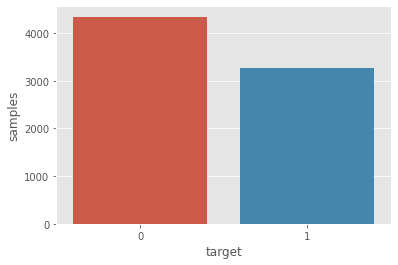

In [ ]:
sns.countplot(data=train_df, x='target')
plt.gca().set_ylabel('samples')

- 0(재난 아님)이 1(실제 재난)보다 많다.
- 실제에서도 0이 1보다 많을 것 예상

#### tweets의 문자 수

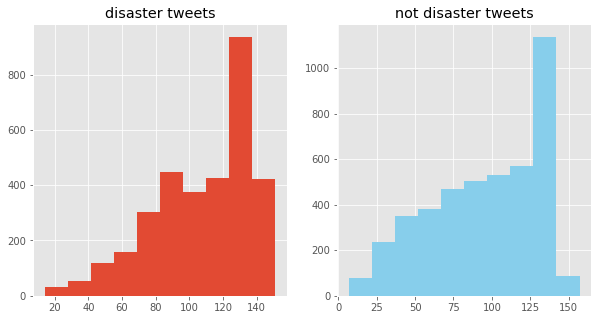

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
# disaster tweets graph
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len)
ax1.set_title('disaster tweets')
# not disaster tweets graph
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len, color="skyblue")
ax2.set_title('not disaster tweets')

plt.show()

- 글자 수가 120-140 사이가 많다.
- 글자 수에서 두 그룹이 큰 차이는 없다. 

#### tweet의 단어 수
- map(함수, 리스트)
  - 리스트에 함수 적용해서 반환
- lambda 인자 : 연산
  - 인자에 연산해서 반환

In [ ]:
print(tweet[tweet['target']==1]['text'].str.split()[:3])

0    [Our, Deeds, are, the, Reason, of, this, #eart...
1       [Forest, fire, near, La, Ronge, Sask., Canada]
2    [All, residents, asked, to, 'shelter, in, plac...
Name: text, dtype: object


In [ ]:
print(tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))[:3])

0    13
1     7
2    22
Name: text, dtype: int64


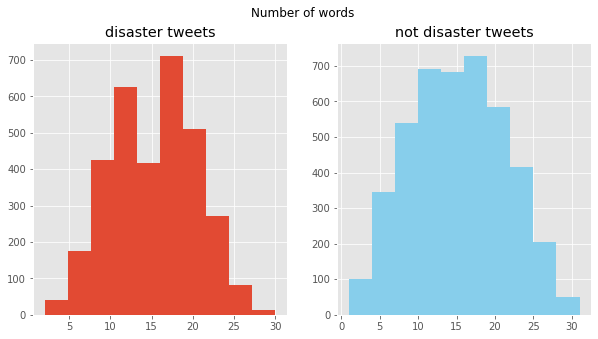

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len)
ax1.set_title('disaster tweets')
tweet_len = tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='skyblue')
ax2.set_title('not disaster tweets')
fig.suptitle('Number of words')

plt.show()

#### 단어 길이의 평균
- apply(): 특정 함수를 데이터 프레임에 적용하는 함수

In [ ]:
word=tweet['text'].str.split().apply(lambda x : [len(i) for i in x])
print(word)

0                [3, 5, 3, 3, 6, 2, 4, 11, 3, 5, 7, 2, 3]
1                                   [6, 4, 4, 2, 5, 5, 6]
2       [3, 9, 5, 2, 8, 2, 6, 3, 5, 8, 2, 9, 2, 5, 10,...
3                             [6, 6, 7, 10, 10, 6, 2, 10]
4       [4, 3, 4, 4, 5, 4, 4, 7, 2, 5, 4, 10, 5, 4, 1, 6]
                              ...                        
7608                   [3, 5, 6, 7, 1, 6, 8, 4, 6, 5, 22]
7609    [12, 12, 3, 3, 2, 7, 4, 5, 2, 10, 4, 2, 3, 8, ...
7610                            [5, 6, 8, 1, 2, 7, 7, 22]
7611    [6, 13, 5, 2, 6, 8, 4, 1, 3, 2, 6, 9, 6, 5, 8,...
7612            [3, 7, 4, 5, 5, 2, 8, 10, 8, 1, 3, 4, 22]
Name: text, Length: 7613, dtype: object


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each tweet')

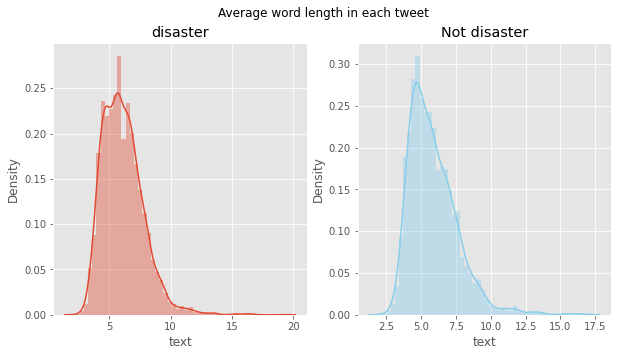

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1)
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='skyblue')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

#### 흔히 쓰이는 stopwords(불용어)
- class 0 부터 보겠다.

#### create_corpus(target)

In [ ]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

<BarContainer object of 10 artists>

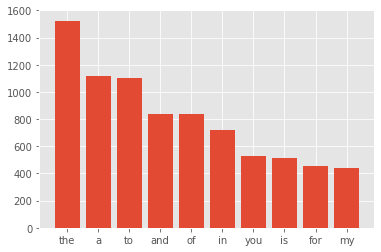

In [ ]:
corpus=create_corpus(0)

dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse = True)[:10]    # count 많은 순대로 정렬
x, y = zip(*top)
plt.bar(x, y)

- class 1

<BarContainer object of 10 artists>

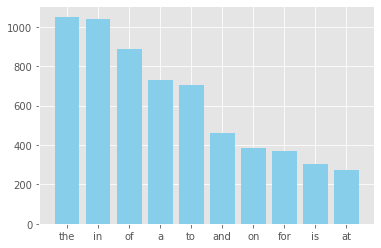

In [ ]:
corpus=create_corpus(1)

dic = defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse = True)[:10]    # count 많은 순대로 정렬
x, y = zip(*top)
plt.bar(x, y, color='skyblue')

- the, in, of, a 가 많이 있다.

#### 구두점(punctuations)
- class 0

<BarContainer object of 20 artists>

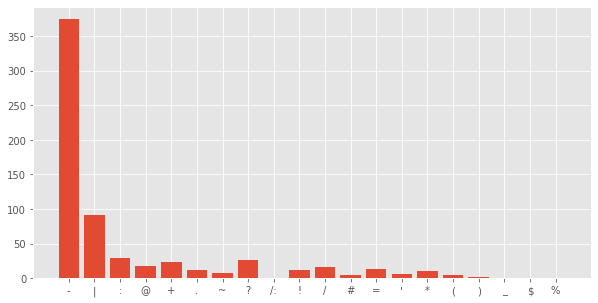

In [ ]:
plt.figure(figsize=(10,5))
corpus = create_corpus(0)

dic = defaultdict(int)
special = string.punctuation
for i in corpus:
  if i in special:
    dic[i] += 1

x, y = zip(*dic.items())
plt.bar(x, y)

<BarContainer object of 18 artists>

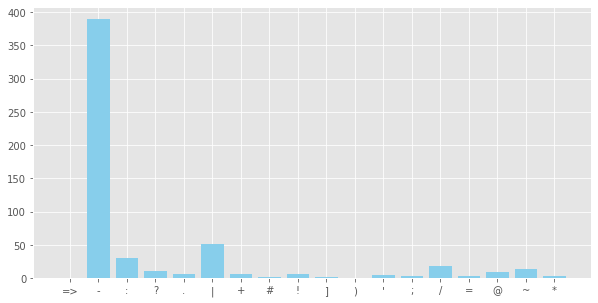

In [ ]:
plt.figure(figsize=(10,5))
corpus = create_corpus(1)

dic = defaultdict(int)
special = string.punctuation
for i in corpus:
  if i in special:
    dic[i] += 1

x, y = zip(*dic.items())
plt.bar(x, y, color='skyblue')

- '-'이 두 class 다 많다.

#### 흔히 쓰이는 단어

In [ ]:
corpus = create_corpus(0)
counter = Counter(corpus)
print(counter)

Counter({'the': 1524, 'a': 1115, 'to': 1099, 'I': 938, 'and': 840, 'of': 834, 'in': 720, 'you': 529, 'is': 512, 'for': 452, 'my': 442, 'on': 387, '-': 374, 'with': 349, 'that': 326, 'The': 295, 'it': 290, 'be': 268, 'like': 233, 'this': 225, 'by': 225, 'have': 219, 'at': 212, 'was': 205, 'your': 201, 'me': 195, 'are': 195, 'just': 193, 'so': 190, '&amp;': 190, "I'm": 185, '??': 183, 'but': 177, 'out': 172, 'up': 167, 'from': 166, 'not': 162, 'will': 146, 'as': 143, 'get': 142, 'or': 139, 'has': 131, 'all': 130, 'about': 128, 'A': 123, 'an': 120, 'i': 114, 'no': 110, 'if': 107, 'can': 107, 'he': 107, 'we': 106, 'when': 106, 'they': 101, 'via': 93, 'into': 93, 'been': 92, '|': 91, 'one': 89, 'do': 89, "don't": 88, 'new': 86, 'his': 86, "it's": 85, 'would': 84, 'her': 82, 'what': 81, 'You': 79, 'My': 78, '2': 78, 'how': 76, 'got': 75, '????': 74, 'more': 73, 'now': 73, 'know': 71, 'New': 69, 'Full': 69, 'If': 68, 'going': 67, 'video': 67, 'see': 66, 'To': 66, 'after': 66, 'In': 65, '@YouT

In [ ]:
most = counter.most_common()
print(most[0], most[1][0][0]) # 빈도, 문자열만 추출

('the', 1524) a


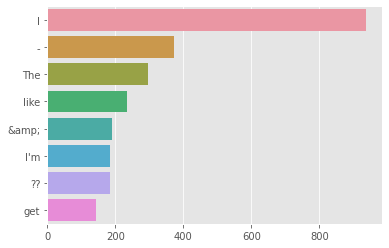

In [ ]:
x =[]
y =[]

for word, count in most[:40]:
  if(word not in stop):   # stop = set(stopwords.words('english'))
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

#### 흔한 Bigrams
- 오,,,코드 모르겠는데:(

In [ ]:
def get_top_bigrams(corpus, n=None):
  vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus) # fit: 말뭉치를 vocabulary로 만들어주는 과정
  bag_of_words = vec.transform(corpus)    #transform: parameter를 vector로 표현해라
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

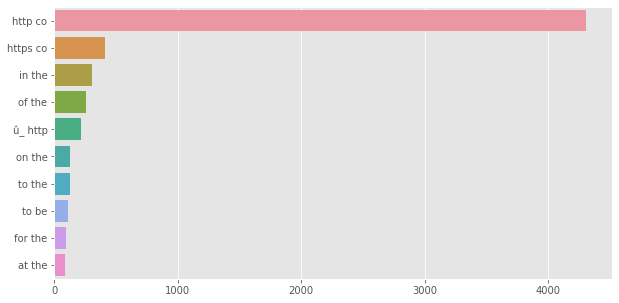

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

## Data Cleaning


In [ ]:
df = pd.concat([train_df, test_df])
df.shape

(10876, 5)

#### removing URLs

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')  # .compile(): 정규식 저장, url.search('문장')으로 활용
    return url.sub(r'',text)    # sub(패턴, 바꿀문자열, 문자열, 바꿀횟수) 

In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

#### removing HTML tags

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_html(x))

#### removing Emojis

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

#### removing punctuations(구두점)

In [ ]:
def remove_punct(text):
  table=str.maketrans('', '', string.punctuation)
  return text.translate(table)

In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

#### spelling correction

In [ ]:
!pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
#df['text']=df['text'].apply(lambda x : correct_spellings(x)#)

- 왜 안했지 

## GloVe for Vectorization
- It is available in 3 varieties :50D ,100D and 200 Dimentional.We will try 100 D here.

In [ ]:
def create_corpus2(df):
    corpus=[]
    
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in set(stopwords.words('english'))))]
        corpus.append(words)
    return corpus

In [ ]:
corpus = create_corpus2(df)

100%|██████████| 10876/10876 [00:24<00:00, 442.96it/s]


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-08-03 10:53:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-08-03 10:53:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-03 10:53:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus) # corpus 빈도수 기준으로 단어 집합 생성
sequences=tokenizer_obj.texts_to_sequences(corpus)


In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

## Baseline Model

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
train=tweet_pad[:train_df.shape[0]]
test=tweet_pad[train_df.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,train_df['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

#### CBOW: Word2Vec
1. 입력받은 문장을 단어로 쪼개고, 중복 제거
2. 단어: 인덱스, 인덱스: 단어를 가지는 사전 선언
3. 학습을 위한 데이터 생성: 예측할 단어 target을 정해주고 주변 단어인 context의 범위도 정함, context-label 쌍을 data리스트에 넣는다.
4. CBOW 모델 정의
5. 모델 선언, loss, optimizer 선언
6. 학습 후 test 진행

In [ ]:
'''
text_list = list(train_df['text'])
clear_text_list = []

for i in tqdm(range(len(text_list))):
  clear_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text_list[i])
  clear_text_list.append(clear_text.lower())

train_df['clear_text'] = clear_text_list
train_df.head()
'''

In [ ]:
'''
text_list = list(test_df['text'])
clear_text_list = []

for i in tqdm(range(len(text_list))):
  clear_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text_list[i])
  clear_text_list.append(clear_text.lower())

test_df['clear_text'] = clear_text_list
test_df.head()
'''

In [ ]:
'''
x_train = []

clear_text_list = list(train_df['clear_text'])

for i in tqdm(range(len(clear_text_list))):
  temp = word_tokenize(clear_text_list[i])    # 토큰화
  x_train.append(temp)

x_train[:3]
'''

In [ ]:
'''
vocab_tmp =[]
for i in tqdm(range(len(x_train))):
  for j in range(len(x_train[i])):
    vocab_tmp.append(x_train[i][j])

vocab_tmp[:15]
'''

In [ ]:
'''
vocab = pd.unique(vocab_tmp).tolist()
vocab_size = len(vocab)
'''

In [ ]:
'''
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for index, word in enumerate(vocab)}
'''

In [ ]:
'''
def make_data(sentence):
  data = []
  for i in range(2, len(temp) -2):
    context = [temp[i-2], temp[i-1], temp[i+1], temp[i + 2]]
    target = temp[i]
    data.append((context, target))
  return data
  '''

In [ ]:
'''
data = make_data(temp)
'''

In [ ]:
'''
# 모델 정의
class CBOW(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super(CBOW, self).__init__()

    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    self.layer1 = nn.Linear(embedding_dim, 64)
    self.activation1 = nn.ReLU()

    self.layer2 = nn.Linear(64, vocab_size)
    self.activation2 = nn.LogSoftmax(dim = -1)

  def forward(self, inputs):
    embeded_vector = sum(self.embeddings(inputs)).view(1,-1)
    output = self.activation1(self.layer1(embeded_vector))
    output = self.activation2(self.layer2(output))
    return output
    '''

In [ ]:
'''
model = CBOW(vocab_size, 128)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# 학습을 진행합니다.
for epoch in range(100):
    total_loss = 0
    for context, target in data:
        context_vector = make_context_vector(context, word_to_index)  
        log_probs = model(context_vector)
        total_loss += loss_function(log_probs, torch.tensor([word_to_index[target]]))
    print('epoch = ',epoch, ', loss = ',total_loss)
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
'''

#### 정규식을 활용한 특수문자 제거
- clear_text에 특수문자를 제거한 tweet
- re.sub(pattern, sub_word, script)
  - pattern: 찾고자 하는 문구
  - sub_word: 바꾸고 싶은 문구
  - script: 문구 찾을 대상

In [ ]:
'''
text_list = list(train_df['text'])
clear_text_list = []

for i in tqdm(range(len(text_list))):
  clear_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text_list[i])
  clear_text_list.append(clear_text.lower())

train_df['clear_text'] = clear_text_list
train_df.head()
'''

In [ ]:
'''
text_list = list(test_df['text'])
clear_text_list = []

for i in tqdm(range(len(text_list))):
  clear_text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text_list[i])
  clear_text_list.append(clear_text.lower())

test_df['clear_text'] = clear_text_list
test_df.head()
'''

#### nltk를 활용해 토큰화/불용어처리/어간추출

In [ ]:
'''
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.tokenize import word_tokenize   # 단어 토큰화
from nltk.stem import LancasterStemmer

stemmer = LancasterStemmer()
'''

- 토큰화 한 단어들에서 어간 추출한 다음 불용어를 제거한 뒤 길이가 2이상인 단어들만 남김

In [ ]:
'''
x_train = []

clear_text_list = list(train_df['clear_text'])

for i in tqdm(range(len(clear_text_list))):
  temp = word_tokenize(clear_text_list[i])    # 토큰화
  temp = [stemmer.stem(word) for word in temp]  # 어간 추출
  temp = [word for word in temp if word not in nltk.corpus.stopwords.words('english')]  # 불용어 제거
  temp = [word for word in temp if len(word) > 1]
  x_train.append(temp)

x_train[:3]
'''

In [ ]:
'''
x_test = []

clear_text_list = list(test_df['clear_text'])

for i in tqdm(range(len(clear_text_list))):
  temp = word_tokenize(clear_text_list[i])    # 토큰화
  temp = [stemmer.stem(word) for word in temp]  # 어간 추출
  temp = [word for word in temp if word not in nltk.corpus.stopwords.words('english')]  # 불용어 제거
  temp = [word for word in temp if len(word) > 1]
  x_test.append(temp)

x_test[:3]
'''

## 각각의 단어를 정수로 인코딩

In [ ]:
'''
words = []

for i in tqdm(range(len(x_train))):
  for j in range(len(x_train[i])):
    words.append(x_train[i][j])

len(list(set(words)))
'''

토큰화, 불용어처리, 어간추출 해서 나온 단어들의 총 개수: 18,168개

In [ ]:
!pip install torchtext